In [1]:
import oceanspy as ospy
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import numpy as np
import scipy as sp

In [2]:
df = xr.open_dataset('C:/Users/eirik/Master/Data/new_dataset.nc')
df_eta = xr.open_dataset('C:/Users/eirik/Master/Data/Eta.nc')

# Starting with defining domain of eddy centerpoint detection and computing eddy centerpoints

In [3]:
domain = [[-20,0],[72,73]]
OW = df['Okubo_Weiss']*(1/(10**(-9)))
eta = df_eta['Eta']
OW = OW.sel(X=slice(domain[0][0],domain[0][1]))
OW = OW.sel(Y=slice(domain[1][0],domain[1][1]))
OW = OW.sel(Z=-1)
eta = eta.sel(X=slice(domain[0][0],domain[0][1]))
eta = eta.sel(Y=slice(domain[1][0],domain[1][1]))

In [4]:
# Resample data to 1 day
OW = OW.resample(time='D').mean(dim='time')
eta = eta.resample(time='D').mean(dim='time')

# Define time extent
time = ['2018-01-01T00:00:00.000000000','2018-02-01T00:00:00.000000000']
eta = eta.sel(time=slice(time[0],time[1]))
OW = OW.sel(time=slice(time[0],time[1]))

In [5]:
# Import algorythm for eddy centerpoint detection
from detection import eddyDetection
import ast

# Set True to run, or read previously file made
run = True
if run:
    eddyLocation = []
    print('###Applying filter###')
    for i in range(len(eta)):
        eddyLocation.append(eddyDetection(eta[i],OW[i]))
        print('Processing: ',100*(i+1)/len(eta), '%')
    with open("eddyCenterpoints.txt",'w') as f:
        for time in range(len(eddyLocation)):
            if time != len(eddyLocation)-1:
                f.write(str(eddyLocation[time])+',')
            else:
                f.write(str(eddyLocation[time]))

else:
    with open("eddyCenterpoints.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)

###Applying filter###


Generating Frames: 100%|██████████| 39/39 [00:16<00:00,  2.34it/s]


Skiped windows %: 89.86969314838167
Processing:  50.0 %


Generating Frames: 100%|██████████| 39/39 [00:15<00:00,  2.49it/s]

Skiped windows %: 89.62349126283551
Processing:  100.0 %


[([[72.085415495, -13.827028024999999],
   [72.146506485, -1.687209394999996],
   [72.187528595, -16.438886585000006],
   [72.187528595, -8.530200194999997],
   [72.20812984, -16.34663061500001],
   [72.29115009, -13.431002524999997],
   [72.312062055, -14.003665869999987],
   [72.312062055, -6.419260315000002],
   [72.460275, -10.21928261],
   [72.460275, -7.875797144999996],
   [72.503229675, -12.643948335],
   [72.503229675, -5.29413407],
   [72.63380034999999, -13.650784999999999],
   [72.67791276999999, -13.299394579999996],
   [72.67791276999999, -8.791000230000003],
   [72.700082895, -4.143556014999996],
   [72.880286815, -15.888078840000006],
   [72.880286815, -13.299394579999996],
   [72.90318058999999, -6.151211045]],
  [[72.12608444, -12.209000324999993],
   [72.146506485, -10.953504109999994],
   [72.187528595, -14.180721069999986],
   [72.27030151, -11.558795389999993],
   [72.29115009, -15.163024134999986],
   [72.312062055, -5.020563484999996],
   [72.460275, -13.5188484

# Defining bigger domain for eddy inner region detection

In [9]:
df_eta = xr.open_dataset('C:/Users/eirik/Master/Data/Eta.nc')

eta = df_eta['Eta']
# Resample data to 1 day
eta = eta.resample(time='D').mean(dim='time')

eta = eta.sel(X=slice(domain[0][0]-1,domain[0][1]+1))
eta = eta.sel(Y=slice(domain[1][0]-1,domain[1][1]+1))
time = ['2018-01-01T00:00:00.000000000','2018-02-01T00:00:00.000000000']
eta = eta.sel(time=slice(time[0],time[1]))

In [10]:
from tqdm import tqdm
from detection import full_inner_eddy_region

eddy_centers = eddyLocation
T = len(eddyLocation) + len(eddyLocation[0][0]) + len(eddyLocation[0][1])
pbar = tqdm(total=T, desc="Running algorythm")
eddies = xr.full_like(eta,fill_value=0)
eddies = eddies.rename("EddyDetection")
for time in range(len(eddyLocation)):
    # First run per time step
    
    
    eddyDataset = full_inner_eddy_region(eta=eta[time],eddy_center=eddy_centers[time][0][0],warm=True,eddiesDataset=eddies[time])
    pbar.update(1)
    for i in range(1,len(eddy_centers[time][0])):
        eddyDataset = full_inner_eddy_region(eta=eta[time],eddy_center=eddy_centers[time][0][i],warm=True,eddiesDataset=eddyDataset)
        pbar.update(1)
        
    for i in range(0,len(eddy_centers[time][1])):
        eddyDataset = full_inner_eddy_region(eta=eta[time],eddy_center=eddy_centers[time][1][i],cold=True,eddiesDataset=eddyDataset)
        pbar.update(1)
        
    pbar.update(1)
    eddies[time] = eddyDataset

Running algorythm: 4it [08:42, 130.55s/it]


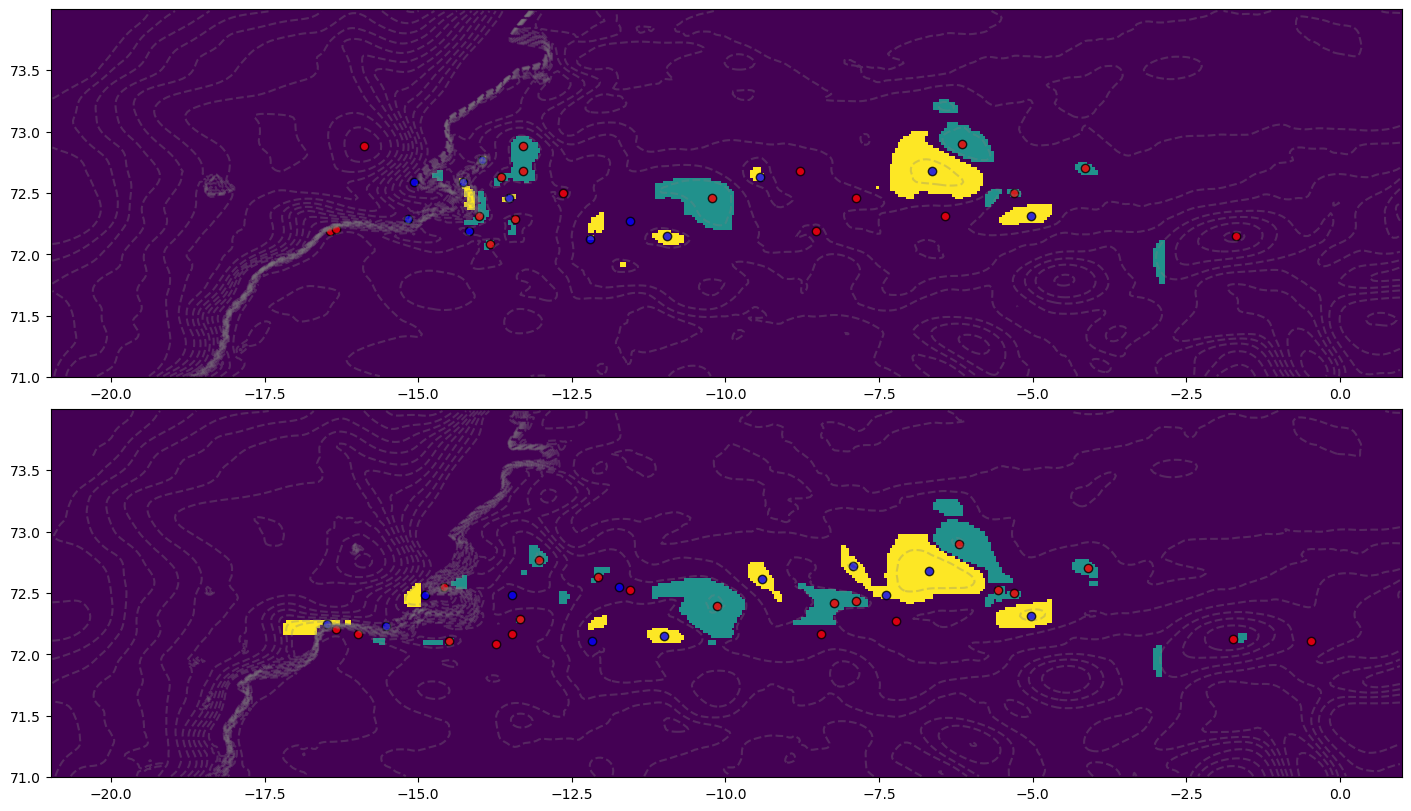

In [13]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8),layout='constrained')
ax1.pcolormesh(eddies[0].X,eddies[0].Y,eddies[0])
cntr = ax1.contour(eta[0].X,eta[0].Y,eta[0],np.linspace(-0.4,0.1,21),colors='grey',alpha=0.3)

for i in eddyLocation[0][0]:
    sct1 = ax1.scatter(i[1],i[0],color='red',edgecolor='black',alpha=0.8)


for i in eddyLocation[0][1]:
    sct2 = ax1.scatter(i[1],i[0],color='blue',edgecolor='black',alpha=0.8)


ax2.pcolormesh(eddies[1].X,eddies[1].Y,eddies[1])
cntr = ax2.contour(eta[1].X,eta[1].Y,eta[1],np.linspace(-0.4,0.1,21),colors='grey',alpha=0.3)

for i in eddyLocation[1][0]:
    sct1 = ax2.scatter(i[1],i[0],color='red',edgecolor='black',alpha=0.8)


for i in eddyLocation[1][1]:
    sct2 = ax2.scatter(i[1],i[0],color='blue',edgecolor='black',alpha=0.8)